# Using CycleGANs to Manipulate Images

Link to GitHub Repo: https://github.com/CJTAYL/CycleGAN

## Introduction to GANs
Generative Adversarial Networks (GANs) are neural nets that can generate data. They are used for a variety of tasks related to image generation or correction, including super resolution images, colorization, and section removal/addition (e.g., removing a stranger from the background of a photo). Their neural nets are comprised of two neural networks – a generator and a discriminator. The generator uses training data to create fake data and a discriminator determines whether the data from the generator are real (labeled 1) or fake (labeled 0). By working against each other, the generator and discriminator become better over the training period. 

## Introduction to CycleGANs

Since the original idea of GANs was proposed by Goodfellow et al. (2014), variants of the idea have emerged, including the Cycle-Consistent Generative Adversarial Network or CycleGAN. The CycleGAN was introduced to perform image-to-image translations without paired training data. Traditional GANs generates new images from samples of noise (i.e., Gaussian distributions), where CycleGANs generate new images by translating an image from domain to a new domain using unpaired datasets. 

### Key Components of CycleGANs
CycleGANs have three key components: 
1. Two generators
2. Two discriminators
3. Three loss functions

## Description of Project and Data
The purpose of this project is to create a set of 7,000 – 10,000 images that have the style of French painter Claude Monet. Based on previous uses of CycleGANs, its architecture is well-suited for the current task. To examine the quality of the images they will be evaluated on the Memorization-informed Fréchet Inception Distance or MiFID. 

The data provided for training consists of 1028 256 x 256 images in either JPEG or TFRecord format. 



In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


# Load and Explore Data

To complete the task, the photograph and Monet datasets should be kept separate. 

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    """
    Modified code written by Jang (2021)
    
    Function to decode a JPEG image to a normalized tensor
    
    Parameters:
    - image = string tensor containing a JPEG image
    
    Returns:
    - Tensor shape (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) with values scaled to [-1, 1].
    """
    # Decode image, covert to float32, and scale pixel values
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1
    # Resize the image to the desired size
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [6]:
def read_tfrecord(example):
    """
    Modified code written by Jang (2021)
    
    Function to parse a single TFRecord into an image.
    
    Parameters:
    - example = scaler string tensor, single serialized example.
    
    Returns:
    - Decoded image tensor
    """
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    # Parse the input
    example = tf.io.parse_single_example(example, tfrecord_format)
    # Decode the image
    image = decode_image(example['image'])
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    """
    Modified code written by Jang (2021)
    
    Function to extract the image from the files.
    """
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
# Load datasets
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# Extract sample of Monet painting
example_monet = next(iter(monet_ds))
# Extract sample photograph
example_photo = next(iter(photo_ds))

## Example from Monet and Photograph Datasets

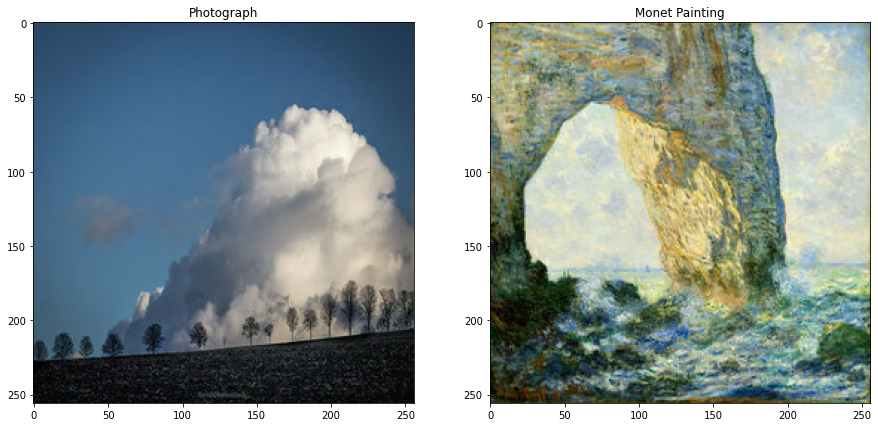

In [9]:
# Display example images of Monet painting and photograph

plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.title('Photograph')
# Adjust colors
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet Painting')
# Adjust colors
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.show()

## Color Analysis

In [10]:
def plot_color_histograms(image_batch):
    """
    Function to plot color histograms for a batch of images
    
    Parameters:
    - image_batch = batch of images
    
    Returns:
    - Three plots showing the red, green, and blue color distributions
    """
    plt.figure(figsize=(12, 5))
    for i, color in enumerate(['red', 'green', 'blue']):
        color_data = image_batch[..., i].numpy().flatten()  # Flatten to 1D array
        plt.subplot(1, 3, i+1)
        plt.hist(color_data, bins=256, color=color, alpha=0.6)
        plt.title(f'{color.capitalize()} Color Distribution')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Color Distributions for Monet Paintings


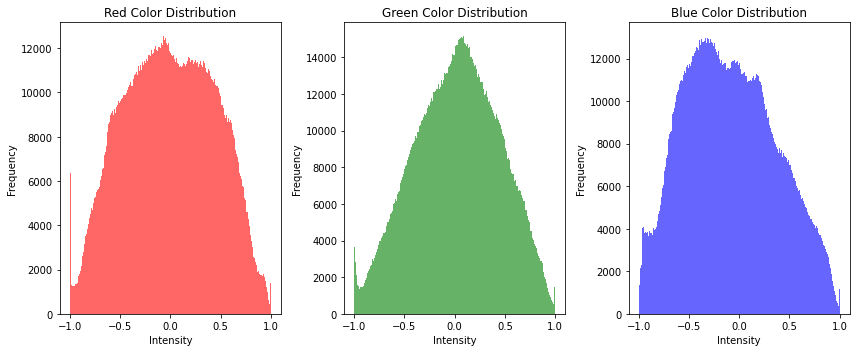

Color Distributions for Photographs


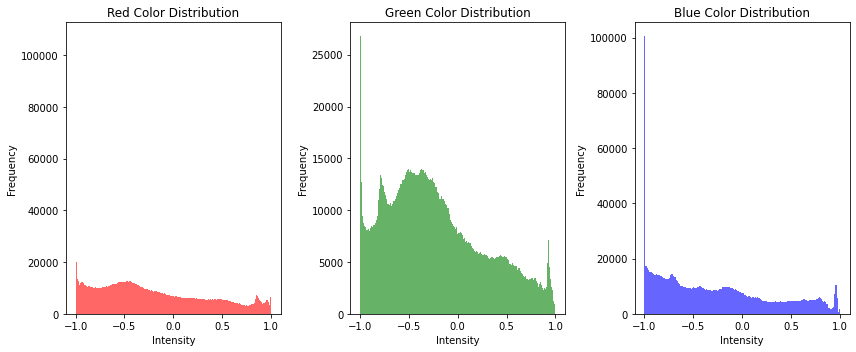

In [11]:
# Separate dataset into batches of 32 images
monet_ds_32 = load_dataset(MONET_FILENAMES, labeled=True).batch(32)
photo_ds_32 = load_dataset(PHOTO_FILENAMES, labeled=True).batch(32)

print('Color Distributions for Monet Paintings')
# Extract the first batch and plot the color histograms for the images 
for image_batch in monet_ds_32.take(1):
    plot_color_histograms(image_batch)
    
print('Color Distributions for Photographs')
for image_batch in photo_ds_32.take(1):
    plot_color_histograms(image_batch)

Based on the color distributions of the sample images, there is a significant difference in the color distributions between the Monet paintings and photographs. Specifically, the Monet painting show more symmetrical distributions, while the photographs show a skewness towards darker tones. These data are consistent with the adjustments that were made on the example images displayed earlier in the report. To address this issue, a function to adjust the brightness in the photographs will be created and applied to the photograph dataset. 

In [12]:
def adjust_images(images):
    """
    Function to adjust images so that their pixel intensity values are scaled from the range [-1, 1]
    to [0, 1], which is a common preprocessing step before displaying the images.

    Parameters:
    - images: A tensor or numpy array representing a batch of images with pixel values in the range [-1, 1].

    Returns:
    - A tensor or numpy array with pixel values scaled to the range [0, 1].
    """
    # Scale and shift the images to the [0, 1] range
    return images * 0.5 + 0.5

In [13]:
# Adjust all photographs and save to new object
adjusted_photo_ds = photo_ds.map(lambda x: adjust_images(x))
# Extract sample from adjusted photographs
adjusted_example_photo = next(iter(adjusted_photo_ds))

# Preparing to Build the Generator and Discriminator

A generator uses training data to create fake data - CycleGANs use two generators (G and F). 
- G translates images from domain A to domain B, represented symbolically as A --> B.
- F translates images from domain B to domain A, represented symbolically as B --> A.

A discriminator determines whether inputted data from the generator are real or from the data distribution ($p_g$) or fake or from the generator distribution ($p_x$). Traditionally, discriminators take inputted data and output 1 if the element is determined to be real or 0 if the element is determined to be fake.

The U-NET architecture was used to build the CycleGAN. Prior to constructing the generator, two helper functions 'downsample' and 'upsample' will be built. In the functions, instance normalization (from TensorFlow Add-ons) will be used instead of batch normalization.

In [14]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, stride=2, mean=0.0, std=0.06, apply_instancenorm=True, instancenorm_epsilon=1e-5):
    """
    Modified code written by Jang (2021)
    
    Function to reduce the spatial dimensions of an image while increasing its number of channels.

    Parameters:
    - filters = number of filters to use in the convolutional layer.
    - size = size of the convolutional filters.
    - stride = stride length of the convolutions.
    - mean = mean value used in initializers
    - std = standard deviation value used in initializers
    - apply_instancenorm = boolean, whether to apply instance normalization.
    - instancenorm_epsilon = small float added to the variance to avoid dividing by zero in instance normalization.

    Returns:
    - A Keras Sequential model that applies a convolution, optional instance normalization, and LeakyReLU activation.
    """
    initializer = tf.random_normal_initializer(mean=mean, stddev=std)
    gamma_init = tf.keras.initializers.RandomNormal(mean=mean, stddev=std)

    result = Sequential()
    result.add(layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    # Apply instance normalization if specified.
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(epsilon=instancenorm_epsilon,
                                                    gamma_initializer=gamma_init))
    # Apply LeakyReLU activation.
    result.add(layers.LeakyReLU())

    return result

In [15]:
def upsample(filters, size, stride=2, mean=0.0, std=0.06, apply_dropout=False):
    """
    Modified code written by Jang (2021)
    
    Function to increase the spatial dimensions of an image while decreasing its number of channels.
    
    Parameters:
    - filters: the number of filters to use in the convolutional layer
    - size: size of the convolutional layer
    - stride: stride length of the convolutions 
    - mean: mean value used in initializers
    - std: standard deviation value used in initializers
    - apply_dropout: boolean, whether to add a dropout layer
    
    Returns:
    - A Keras Sequential model that applies a transposed convolution, instance normalization, 
      optional dropout layer, and ReLU activation.
    """
    initializer = tf.random_normal_initializer(mean=mean, stddev=std)
    gamma_init = keras.initializers.RandomNormal(mean=mean, stddev=std)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=stride, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())

    return result


## Build the Generator

In [16]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    # Define downsampling layers
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    
    # Define upsampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    # Apply final layers
    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Build the discriminator

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

def Discriminator():
    # Initializer for the Conv layers
    initializer = tf.random_normal_initializer(0., 0.02)
    # Initializer for the InstanceNormalization layers
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Input layer
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    # Downsampling through the discriminator
    down1 = downsample(64, 4, apply_instancenorm=False)(inp)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    # Zero padding and Convolution to increase the receptive field
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    # Instance normalization
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    # Leaky ReLU for non-linearity
    leaky_relu = layers.LeakyReLU()(norm1)

    # Another zero padding followed by a Convolution to get to the final output
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    # Create and return the model
    return tf.keras.Model(inputs=inp, outputs=last)


In [18]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

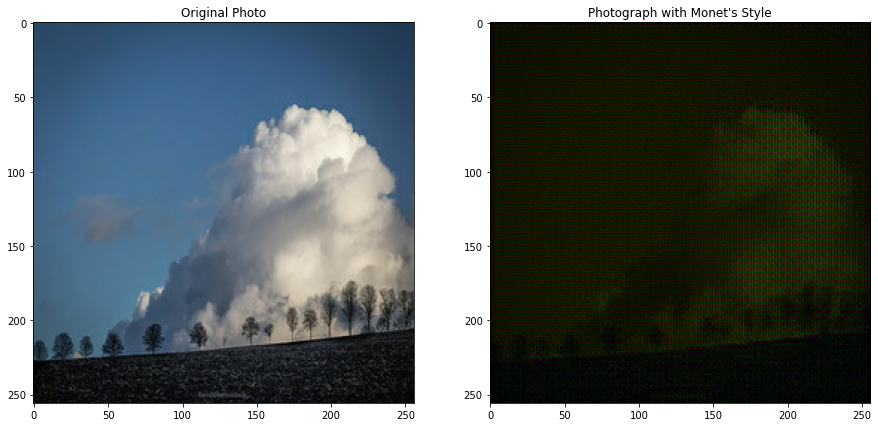

In [19]:
to_monet = monet_generator(adjusted_example_photo)

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.axis('on')
# Adjust color values
plt.imshow(adjusted_example_photo[0])

plt.subplot(1, 2, 2)
plt.title("Photograph with Monet's Style")
plt.axis('on')
# Adjust color values
plt.imshow(to_monet[0])
plt.show()

The generators have not been trained yet, therefore, the photograph with Monet's style is not displaying correctly. 

# Build the CycleGAN model

In [51]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define Loss Functions

One component of CycleGANs is their use of three loss functions. 
1. Adversarial Loss (GAN loss): Measures if generated data is indistinguishable from real data.
2. Cycle Consistency Loss: Measures if an image can be translated from one domain (i.e., photographs) to the other (i.e., photographs with Monet's style), then back to its original domain. 
3. Identify Loss: Encourages the generator to be an identity function when real data are inputted. In other words, refraining from altering an element when it comes from the real data domain. 


The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [52]:
with strategy.scope():
    def discriminator_loss(real, generated):
        """
        Modified code written by Jang (2021)
        
        Function to calculate the discriminator loss for the GAN loss
        
        Parameters:
        - real = discriminators predictions on real images. Elements determined to be real should have values close to 1 
        - generated = discriminators predictions on generated (fake) images. Elements determined to be generated should have values close to 0
        
        Returns:
        - Tensor representing the loss value for the discriminator 
        """
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        
        # Multiply by 0.5 to help stablize training
        return total_disc_loss * 0.5

In [53]:
with strategy.scope():
    def generator_loss(generated):
        """
        Modified code written by Jang (2021)
        
        Function to calculate the generator loss for the GAN loss
        
        Parameters
        - generated = The discriminator's output logits (raw, unnormalized outputs of a model's last linear layer)for the generated iamges
        
        Returns 
        - Tensor representing the loss value for the generator
        """
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [54]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, lambda_value):
        """
        Modified code written by Jang (2021)
        
        Function that calculates the cycle consistency loss between a real and fake (cycled image).
        
        Parameters:
        - real_image = tensor representing the original image 
        - cycled_image = tensor representing the image that was translated from its domain to a new domain, then back to its original domain. 
        - LAMBDA = scaler that controls the importance of the cycle consistency loss in the overall loss function
        
        Returns:
        - Cycle consistency loss that has been scaled by LAMBDA 
        
        """
        # Calculate the mean absolute error between the real and cycled images
        cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        # Scale cycle_loss by lambda_value
        return lambda_value * cycle_loss

In [55]:
with strategy.scope():
    def identity_loss(real_image, same_image, lambda_value):
        """
        Modified code written by Jang (2021)
        
        Function to calcualte identity loss.
        
        Parameters:
        - real_image = tensor of the original image from the target domain.
        - same_image = tensor of the output image produced by the generator when 'real_image' is 
                      given as input.
        - lambda_value = A scalar that weights the importance of the identity loss within the total 
                        loss function.

        Returns:
        - The weighted identity loss, calculated as the mean absolute error between 'real_image' and 
          'same_image', scaled by 'lambda_value' and a factor of 0.5 to adjust its overall impact.
        """
        # Calculate the mean absolute error between the real and same images
        identity_loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        # Scale identify loss by lambda_value and factor of 0.5
        return lambda_value * 0.5 * identity_loss

# Analysis

## Train the CycleGAN

In [56]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [57]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [58]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, adjusted_photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 180s 453ms/step - monet_gen_loss: 4.7999 - photo_gen_loss: 4.6535 - monet_disc_loss: 0.5223 - photo_disc_loss: 0.5089
Epoch 2/25
300/300 [==============================] - 136s 451ms/step - monet_gen_loss: 3.8171 - photo_gen_loss: 3.5929 - monet_disc_loss: 0.6045 - photo_disc_loss: 0.6240
Epoch 3/25
300/300 [==============================] - 136s 451ms/step - monet_gen_loss: 3.3918 - photo_gen_loss: 3.2187 - monet_disc_loss: 0.6233 - photo_disc_loss: 0.6425
Epoch 4/25
300/300 [==============================] - 136s 451ms/step - monet_gen_loss: 3.0843 - photo_gen_loss: 2.9820 - monet_disc_loss: 0.6498 - photo_disc_loss: 0.6535
Epoch 5/25
300/300 [==============================] - 136s 451ms/step - monet_gen_loss: 2.8595 - photo_gen_loss: 2.9043 - monet_disc_loss: 0.6622 - photo_disc_loss: 0.6140
Epoch 6/25
300/300 [==============================] - 135s 451ms/step - monet_gen_loss: 2.8202 - photo_gen_loss: 3.0634 - monet_disc_loss: 0

## Visualize Photographs with Monet's Style

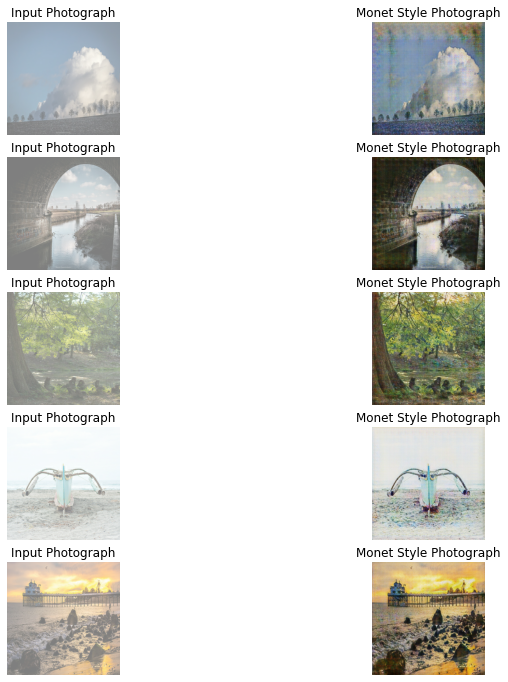

In [62]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(adjusted_photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photograph")
    ax[i, 1].set_title("Monet Style Photograph")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create Submission Zip File

In [63]:
import PIL
! mkdir ../images

mkdir: cannot create directory ‘../images’: File exists


In [64]:
i = 1
for img in adjusted_photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [65]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Results and Conclusion

After submitting the zip file to the Kaggle competition, a MiFID score of 51.7618 was obtained. 

### Learning and Takeaways

In general, building  neural networks can require a significant amount of code; threfore, it's important to check the code frequently for inconsistencies and typos. Additionally, training can be time intensive and computationally expensive, so it's important to allocate those resources wisely during development. 

With this project, it was beneficial to determine if there were extreme differences in the color distributions of domain A (Monet painting) and domain B (photographs) before starting training to help the model avoid being "confused" by drastic differences in colors.   

### What Didn't work

Overall, the results of the model are satisfactory. I attempted to create a function to match color histograms from the images in photograph dataset to those of Monet dataset; however, the code would not run correctly. Ultimately, I opted to use a more simple approach that increased the color intensity of the images in the photo dataset in an effort to make their distributions more symmetrical, like the images in the Monet dataset. 

### Possible Improvements

If I had more experience/knowledge in working with image data and preprocessing, I could have potentially made improvements to the model. Additionally, with more time, I could run additional epochs, learn more about tuning the model's hyperparameters, and gain a deeper understanding of how CycleGANs can be optimized. 

# References

Géron, A. (2023). *Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow: concepts, Tools, and Techniques to Build Intelligent Systems* (3rd ed.) O'Reilly.

Goodfellow, I.J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). *Generative Adversarial Nets*  
https://arxiv.org/abs/1406.2661.

Jang, A. (2021). *Monet CycleGAN Tutorial, Version 12*
Retrieved February 19 from https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial.

Zhu, J. Park, T., Isola, P., Efros, A. (2017). *Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks*, in IEEE International Conference on Computer Vision (ICCV). 